<a href="https://colab.research.google.com/github/trystine/Rock-or-Paper--Hand-Recognition/blob/main/Hand_RecognitionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setting Up Kaggle so that we can import the Rock, Paper and Scissors datasets through API

In [1]:
!pip install kaggle

In [ ]:
!mkdir kaggle

In [5]:
import json
token = {"username":"trystine","key":"55159c476863b8231564f20099f8192d"}
with open('/content/kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [9]:
!cp /content/kaggle/kaggle.json ~/.kaggle/kaggle.json


In [10]:
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json

- path is now set to: {/content}


In [11]:
!kaggle datasets download -d drgfreeman/rockpaperscissors

 99% 303M/306M [00:02<00:00, 187MB/s]
100% 306M/306M [00:02<00:00, 155MB/s]


In [12]:
!unzip /content/{/content}/datasets/drgfreeman/rockpaperscissors/rockpaperscissors.zip

Archive:  /content/{/content}/datasets/drgfreeman/rockpaperscissors/rockpaperscissors.zip
  inflating: README_rpc-cv-images.txt  
  inflating: paper/04l5I8TqdzF9WDMJ.png  
  inflating: paper/0Og76sl5CJhbxWWx.png  
  inflating: paper/0RA9rcrv8iVvuDDU.png  
  inflating: paper/0Uomd0HvOB33m47I.png  
  inflating: paper/0a3UtNzl5Ll3sq8K.png  
  inflating: paper/0cb6cVL8pkfi4wF6.png  
  inflating: paper/0eqArS2GgsBeqgSn.png  
  inflating: paper/0t08v9bAaA0mXGCQ.png  
  inflating: paper/0vugygEjxQJPr9yz.png  
  inflating: paper/0zKU6wEhT2cDe9j0.png  
  inflating: paper/14K62H4KG1hg5qiJ.png  
  inflating: paper/1Dfw5FRlS4h60JPX.png  
  inflating: paper/1Frbe8cdOdkciOBg.png  
  inflating: paper/1Tt9U9SzrOm98Xtw.png  
  inflating: paper/1fKclJk4eBWOQSR1.png  
  inflating: paper/1jHtb93pI8f6pfKo.png  
  inflating: paper/1oKnUgV2CdCaQUUX.png  
  inflating: paper/1uoW7QcH2qAgCTxv.png  
  inflating: paper/1yKjzquSvl9ShK7K.png  
  inflating: paper/1yeoLbmp4alVOtFv.png  
  inflating: paper/27XFtQjjXQ8

### Next we will be deleting the scissors label dataset from the imported data because loss functions like sparse_categorical_crossentropy is not working with the newer versions of keras and tensorflow on colab. So we will be training only a binary classification model.

In [13]:
import shutil

shutil.rmtree('/content/rps-cv-images/scissors')

### Importing the necessary APIs and Libraries. 

In [14]:
import tensorflow 
from tensorflow import keras
from keras_preprocessing import image 
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import numpy as np
import os
from keras.models import Sequential
from keras.layers import Dense
#import keras.layers as layers


In [15]:
# define path and catogories for classification
path_dir = "/content/rps-cv-images"
categories = ["paper", "rock"]

print("Loading the images")
# make arrays for storing dataset of images and it's label of 
# Paper or Rock
dataset = []
label = []
# join path for preprocessing of images
for category in categories:
    path = os.path.join(path_dir, category)
    for img in os.listdir(path):
      img_path = os.path.join(path, img)
      Img = keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
      Img = keras.preprocessing.image.img_to_array(Img)
      Img=keras.applications.xception.preprocess_input(Img)
      
      dataset.append(Img)
      label.append(category)

print("All images loaded successfully")

Loading the images
All images loaded successfully


### Next We will encode our labels into 0 and 1. There are various methods like OnehotEncoder, LabelEncoder and LabelBinarizer. The only difference is the format in which one get's their label encoded.

In [16]:

# Convert two categories into binary format like 0,1
label_binarizer = LabelBinarizer()
# Transform multi-class labels to binary labels
label = label_binarizer.fit_transform(label)
# Converts a class vector (integers) to binary class matrix
label = keras.utils.to_categorical(label)
label

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

### Convertin Dataset and Labels to Array. So that we can easily feed them to train our deep learning model

In [17]:
dataset = np.array(dataset, dtype="float32")
label = np.array(label)

In [18]:
ts = 0.3 # Percentage of images that we want to use for testing. The rest is used for training.
X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size=ts, random_state=42)

### Using Data Augmentation to introduce some variation

In [19]:
#use augmentation to increase variation in dataset by various operation like shifting and rotating images
data_augmentation = keras.preprocessing.image.ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.07,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.10, 
	horizontal_flip=True,
	fill_mode="nearest")

### We would be using Xception Model with predefined weights for training our data

In [20]:
base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False, input_tensor=keras.layers.Input(shape=(224, 224, 3)))
# we will freeze the base model to prevent them from updation while training
for layer in base_model.layers:
	layer.trainable = False

83689472/83683744 [==============================] - 0s 0us/step


### Finally we will make a Sequence of our Xception Model followed by couple of other layers like GlobalAveragePooling Layer and a softmax dense layer to get our output with two units.

In [21]:
model = tensorflow.keras.Sequential(
    [keras.Input(shape=(224, 224, 3)),
     base_model,
     keras.layers.GlobalAveragePooling2D(),
     keras.layers.Dense(2, activation="softmax"),
     ] 
)

In [22]:
#print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 20,865,578
Trainable params: 4,098
Non-trainable params: 20,861,480
_________________________________________________________________


In [23]:
# Configures the model for training
model.compile(optimizer='adam', # Optimization routine, which tells the computer how to adjust the parameter values to minimize the loss function.
              loss='binary_crossentropy', # Loss function, which tells us how bad our predictions are.
              metrics=['accuracy']) # List of metrics to be evaluated by the model during training and testing.

In [24]:
#Training
EPOCHS =10
batchSize = 40
FIT = model.fit(
	data_augmentation.flow(X_train, y_train, batch_size=batchSize),
	steps_per_epoch=len(X_train) // batchSize,
	validation_data=(X_test, y_test),
	validation_steps=len(X_test) // batchSize,
	epochs= EPOCHS)

Epoch 1/10
25/25 [==============================] - 197s 8s/step - loss: 0.5944 - accuracy: 0.6748 - val_loss: 0.2883 - val_accuracy: 0.9421
Epoch 2/10
25/25 [==============================] - 196s 8s/step - loss: 0.2475 - accuracy: 0.9491 - val_loss: 0.1861 - val_accuracy: 0.9537
Epoch 3/10
25/25 [==============================] - 196s 8s/step - loss: 0.1508 - accuracy: 0.9811 - val_loss: 0.1449 - val_accuracy: 0.9583
Epoch 4/10
25/25 [==============================] - 196s 8s/step - loss: 0.1123 - accuracy: 0.9855 - val_loss: 0.1107 - val_accuracy: 0.9815
Epoch 5/10
25/25 [==============================] - 196s 8s/step - loss: 0.0913 - accuracy: 0.9928 - val_loss: 0.0943 - val_accuracy: 0.9838
Epoch 6/10
25/25 [==============================] - 196s 8s/step - loss: 0.0922 - accuracy: 0.9858 - val_loss: 0.0854 - val_accuracy: 0.9815
Epoch 7/10
25/25 [==============================] - 197s 8s/step - loss: 0.0907 - accuracy: 0.9857 - val_loss: 0.0755 - val_accuracy: 0.9861
Epoch 8/10
25

### Let's see the Prediction on X_test Set

In [25]:

PREDICT = model.predict(X_test, batch_size=batchSize)

In [26]:
PREDICT

array([[9.99987006e-01, 1.29581495e-05],
       [1.24011322e-05, 9.99987602e-01],
       [8.67585404e-05, 9.99913216e-01],
       [9.26315697e-05, 9.99907374e-01],
       [9.96058702e-01, 3.94126587e-03],
       [7.46378500e-04, 9.99253571e-01],
       [9.28288428e-05, 9.99907136e-01],
       [1.81831449e-01, 8.18168581e-01],
       [1.32956455e-04, 9.99867082e-01],
       [9.99999881e-01, 1.53453826e-07],
       [9.99999404e-01, 6.18040758e-07],
       [5.09631413e-04, 9.99490380e-01],
       [9.99995351e-01, 4.63336846e-06],
       [1.97678237e-04, 9.99802291e-01],
       [9.93748195e-04, 9.99006331e-01],
       [2.14065844e-03, 9.97859299e-01],
       [9.99998808e-01, 1.13850342e-06],
       [8.84158129e-04, 9.99115884e-01],
       [8.87105584e-01, 1.12894394e-01],
       [2.01023417e-03, 9.97989774e-01],
       [9.66510534e-01, 3.34894881e-02],
       [9.99985218e-01, 1.47338387e-05],
       [9.91085231e-01, 8.91471934e-03],
       [9.99877691e-01, 1.22338039e-04],
       [2.066111

### Saving the trained Model

In [28]:
model.save("HAND_detector.model", save_format="h5")


### Prediction on Input image through real time Webcam Capture whose code snippet is available through colab

In [29]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


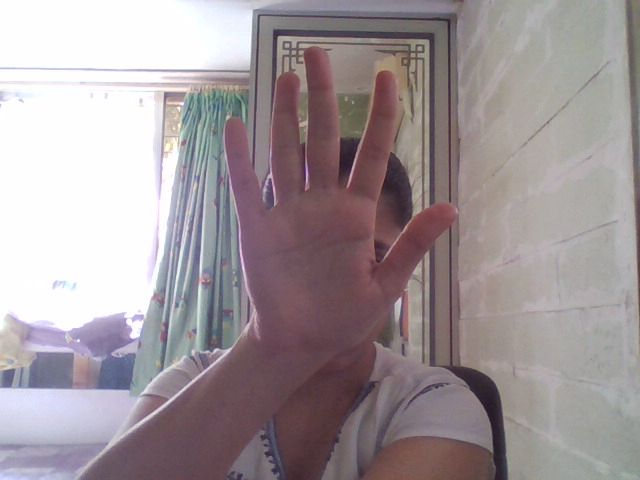

In [31]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

###Loading and Preprocessing the Input Image for our model. Note that it is important to preprocess your input image as model was trained by preprocessing our dataset. Hence the unseen input image should also go through the same procedure

In [32]:
ha="/content/photo.jpg"
image = keras.preprocessing.image.load_img(ha, target_size=(224, 224)) #Loaing the image through path
image = keras.preprocessing.image.img_to_array(image) 
image=keras.applications.xception.preprocess_input(image) #Preprocess the data based on the Xception model
image=np.array(image, dtype="float32") #Converting the image to array
image = np.expand_dims(image, axis=0) #This is used to create another dimension of the input image which is 4D since Xception model required 4 input dimensions

In [33]:
image.shape

(1, 224, 224, 3)

In [34]:
new_predict = model.predict(image)
new_predict = new_predict.argmax(axis=-1)
new_predict
if new_predict==0:
  print("paper")
else:
  print("rock")


paper


References:

https://www.kaggle.com/drgfreeman/rockpaperscissors

https://keras.io/api/applications/xception/

https://github.com/abcom-mltutorials/mask-detector

https://github.com/filipefborba/HandRecognition





